In [4]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

#disable_eager_execution()

In [11]:
batch_size = 1
time_step = 5
signal_length = 3
sequences = np.random.rand(batch_size, time_step, 1)
seq_lengths = np.array([signal_length]*batch_size)
signal_mask = np.random.randint(5, size=(batch_size, time_step))

    


In [12]:
dataset = tf.data.Dataset.from_tensor_slices(((sequences, seq_lengths),  signal_mask)).repeat(10).batch(2)
batch, _ = next(iter(dataset))

In [13]:
x = batch[0]
x

<tf.Tensor: shape=(2, 5, 1), dtype=float64, numpy=
array([[[0.35912527],
        [0.6299836 ],
        [0.17180507],
        [0.34914738],
        [0.1625943 ]],

       [[0.35912527],
        [0.6299836 ],
        [0.17180507],
        [0.34914738],
        [0.1625943 ]]])>

In [14]:
conv = layers.Conv1D(32, 3, strides=1, padding='same', activation='relu')
#masked = layers.Masking(mask_value=0)

In [15]:
x1 = conv(x)
x1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(2, 5, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.01264762, 0.        ,
         0.01272679, 0.13099056, 0.07797258, 0.15831651, 0.18113688,
         0.01516803, 0.04307875, 0.        , 0.        , 0.        ,
         0.10110074, 0.02121873, 0.        , 0.11789553, 0.        ,
         0.07170302, 0.        , 0.08771796, 0.03895834, 0.12965615,
         0.        , 0.01667519, 0.        , 0.04554652, 0.02077863,
         0.05445584, 0.2026338 ],
        [0.05430221, 0.        , 0.        , 0.03236622, 0.        ,
         0.        , 0.14047867, 0.05656818, 0.14380452, 0.16455247,
         0.        , 0.06488179, 0.        , 0.        , 0.01768948,
         0.1773797 , 0.1886166 , 0.        , 0.17743854, 0.01033514,
         0.04733446, 0.07556552, 0.08676696, 0.        , 0.00891674,
         0.04602535, 0.08088142, 0.        , 0.11517064, 0.        ,
         0.        , 0.14350991],
        [0.00754514, 0.04775027, 0.        , 0.     

In [24]:
x2 = masked(x1)
x2._keras_mask

<tf.Tensor: shape=(1, 5), dtype=bool, numpy=array([[ True,  True,  True,  True,  True]])>

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0', '/device:GPU:1')
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CollectiveCommunication.AUTO
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_data (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     128         seq_data[0][0]                   
__________________________________________________________________________________________________
masking (Masking)               (None, None, 32)     0           conv1d[0][0]                     
______________________________________

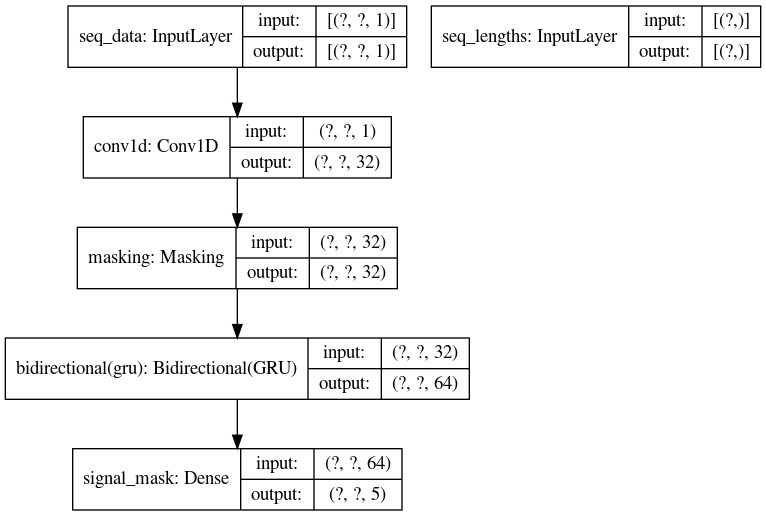

In [4]:
def model2(mask_value):
    mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
                        
    with mirrored_strategy.scope():
        seq_data = keras.Input(shape=(None, 1),  name="seq_data")
        seq_lengths = keras.Input(shape=(), name="seq_lengths", dtype=tf.int32)

        #mask = keras.layers.Lambda(lambda x: tf.sequence_mask(x))(seq_lengths)
        conv = layers.Conv1D(32, 3, strides=1, padding='same', activation='relu')(seq_data)
        #rnn = layers.Bidirectional(layers.GRU(32, return_sequences=True))(conv,mask=mask)
        masked = layers.Masking(mask_value=mask_value)(conv)
        rnn = layers.Bidirectional(layers.GRU(32, return_sequences=True))(masked)
        dense = layers.Dense(5, name="signal_mask")(rnn)
        model = keras.Model(inputs=[seq_data, seq_lengths], outputs=[dense])

        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=0.001),
            loss=tf.keras.backend.sparse_categorical_crossentropy
        )
    
    return model

model2 = model2(0.0)
print(model2.summary())
dot_img_file = 'model_2.png'
tf.keras.utils.plot_model(model2, to_file=dot_img_file, show_shapes=True)

In [ ]:
batch_size = 1
time_step = 1000
signal_length = 1000
sequences = np.random.rand(batch_size, time_step, 1)
seq_lengths = np.array([signal_length]*batch_size)
signal_mask = np.random.randint(5, size=(batch_size, time_step))

    
dataset = tf.data.Dataset.from_tensor_slices(((sequences, seq_lengths),  signal_mask)).repeat(10).batch(1)


model2.fit(dataset, epochs=1)

In [ ]:
batch_size = 1
time_step = 6
signal_length = 6
sequences = np.random.rand(batch_size, time_step, 1)
seq_lengths = np.array([signal_length]*batch_size)
signal_mask = np.random.randint(5, size=(batch_size, time_step))

    
dataset = tf.data.Dataset.from_tensor_slices(((sequences, seq_lengths),  signal_mask)).repeat(10).batch(2)
batch = next(iter(dataset))
batch

In [ ]:
%%writefile config.yaml
trainingInput:
  scaleTier: CUSTOM
  # Configure a master worker with 1 with K80 GPUs
  masterType: n1-highcpu-16
  masterConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_K80
  # Configure 1 worker(s), each with 2 K80
  workerCount: 1
  workerType: n1-highcpu-16
  workerConfig:
    acceleratorConfig:
      count: 2
      type: NVIDIA_TESLA_K80

In [ ]:
%%bash

now=$(date +"%Y%m%d_%H%M%S")
JOB_NAME="multi_cpu_fashion_minst_$now"

gcloud ai-platform jobs submit training $JOB_NAME \
  --staging-bucket=gs://mlops-dev-workspace \
  --package-path=sample \
  --module-name=sample.model \
  --runtime-version=2.1 \
  --python-version=3.7 \
  --region=us-west1 \
  --config config.yaml
  

In [ ]:
!gcloud ai-platform jobs stream-logs multi_cpu_fashion_minst_20200805_040150